
Class counts (class names):
leopard      200
cougar       116
flamingo     112
crocodile    107
butterfly     93
kangaroo      86
scorpion      84
llama         78
crab          73
crayfish      72
dragonfly     68
dolphin       65
elephant      64
rhino         59
beaver        46
pigeon        45
lobster       44
octopus       36
Name: count, dtype: int64

New class counts after augmentation (class names):
leopard      200
scorpion     200
llama        200
beaver       200
crayfish     200
crab         200
lobster      200
cougar       200
butterfly    200
dragonfly    200
pigeon       200
flamingo     200
dolphin      200
kangaroo     200
elephant     200
octopus      200
rhino        200
crocodile    200
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.0683 - loss: 2.8715 - val_accuracy: 0.1042 - val_loss: 2.8168 - learning_rate: 0.0010
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.1357 - loss: 2.7202 - val_accuracy: 0.1708 - val_loss: 2.6159 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2134 - loss: 2.5141 - val_accuracy: 0.3500 - val_loss: 2.2380 - learning_rate: 0.0010
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2968 - loss: 2.2453 - val_accuracy: 0.3653 - val_loss: 2.0797 - learning_rate: 0.0010
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3841 - loss: 1.9652 - val_accuracy: 0.5069 - val_loss: 1.6213 - learning_rate: 0.0010
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5072 - loss: 1.5935 - val_accuracy: 0.5736 - val_loss: 1.3351 - learning_rate: 0.0010
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5944 - loss: 1.3140 - val_accuracy: 0.61

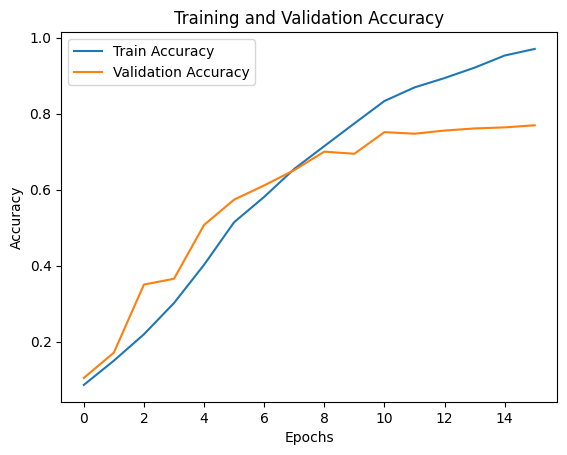

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9591 - loss: 0.1889
Training accuracy: 96.11%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7463 - loss: 0.9052
validation accuracy: 75.14%
Model saved successfully.


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import random
import matplotlib.pyplot as plt
import cv2

# === Step 1: Define Paths ===
image_folder = r"/kaggle/input/animal-kingdom-classification/AnimalTrainData/AnimalTrainData"
csv_path = r"/kaggle/input/animal-kingdom-classification/AnimalTrainData/AnimalTrainData/train.csv"

# === Step 2: Load CSV File ===
df = pd.read_csv(csv_path)

# === Step 3: Create a Mapping of Class Names to Integer Labels ===
class_mapping = {
    "beaver": 0, "butterfly": 1, "cougar": 2, "crab": 3, "crayfish": 4,
    "crocodile": 5, "dolphin": 6, "dragonfly": 7, "elephant": 8, "flamingo": 9,
    "kangaroo": 10, "leopard": 11, "llama": 12, "lobster": 13, "octopus": 14,
    "pigeon": 15, "rhino": 16, "scorpion": 17
}

# === Step 4: Map Image Names to Classes (Integer Labels) ===
image_to_class = dict(zip(df['ImageID'], df['Class']))

def preprocess_image(image_path, target_size=(224, 224)):  # ResNet/Inception requires 224x224 input
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded.")

    image_resized = cv2.resize(image, target_size)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image_normalized = image_rgb / 255.0
    return image_normalized

# === Step 5: Load Images and Assign Classes ===
image_data = []
labels = []

for file_name in os.listdir(image_folder):
    if file_name in image_to_class:
        image_path = os.path.join(image_folder, file_name)
        if os.path.isfile(image_path):
            try:
                image_array = preprocess_image(image_path)
                image_data.append(image_array)
                class_name = image_to_class[file_name]
                label = class_mapping.get(class_name, -1)
                if label != -1:
                    labels.append(label)
                else:
                    print(f"Class {class_name} not found in mapping.")
            except (IOError, ValueError) as e:
                print(f"Error reading image {file_name}: {e}")

# Convert to numpy arrays for Keras
image_data = np.array(image_data)
labels = np.array(labels)

# === Step 6: Class Distribution Analysis ===
class_counts = pd.Series(labels).value_counts()
class_names = {v: k for k, v in class_mapping.items()}  # Reverse the mapping
class_counts_named = class_counts.rename(index=class_names)

print("\nClass counts (class names):")
print(class_counts_named)

# === Step 7: Balance Classes to Max Class Size Using Augmentation ===
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

max_class_size = class_counts.max()  # Maximum size among all classes
augmented_images = []
augmented_labels = []

for label in np.unique(labels):
    class_images = image_data[labels == label]
    current_class_size = class_counts[label]

    augmented = datagen.flow(class_images, batch_size=1)
    for _ in range(max_class_size - current_class_size):
        augmented_images.append(next(augmented)[0])
        augmented_labels.append(label)

if augmented_images:  # Ensure there are augmented images to add
    image_data = np.concatenate([image_data, np.array(augmented_images)])
    labels = np.concatenate([labels, np.array(augmented_labels)])

# Check new class distribution
new_class_counts = pd.Series(labels).value_counts()
new_class_counts_named = new_class_counts.rename(index=class_names)

print("\nNew class counts after augmentation (class names):")
print(new_class_counts_named)

# === Step 8: Define CNN Model ===
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_mapping), activation='softmax')  # Output layer with softmax activation
])

# === Step 9: Compile the Model ===
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# === Step 10: Define Callbacks ===
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# === Step 11: Train the Model ===
datagen = ImageDataGenerator(validation_split=0.2)

train_gen = datagen.flow(image_data, labels, batch_size=32, subset='training')
val_gen = datagen.flow(image_data, labels, batch_size=32, subset='validation')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

# === Step 12: Plot Training History ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# === Step 13: Evaluate the Model ===
train_loss, train_acc = model.evaluate(train_gen)
print(f"Training accuracy: {train_acc * 100:.2f}%")

val_loss, val_acc = model.evaluate(val_gen)
print(f"validation accuracy: {val_acc * 100:.2f}%")

model.save("animal_cnn_model.h5")  # Save the model in HDF5 format
print("Model saved successfully.")